In [1]:
import pandas as pd
import csv
import langid
import numpy as np
import requests
import json
import re
import string
import nltk
import unicodedata
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# download the Indonesian stopwords from NLTK
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irfan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load data
data = pd.read_csv('Bahan/04.IbuKotaNegara.csv', encoding='utf-8')
print (data)

     Unnamed: 0                                         text_tweet
0           626  @KoalisiNetizen Peningkatan akses transportasi...
1           629  Seorang Warga negara haram Isr4el Avitan Shalo...
2           847  Menteri PUPR Basuki Hadimuljono mengungkapkan ...
3           514  Ternyata masalah lahan di Ibu Kota Negara (IKN...
4           365  Sebuah langkah besar menuju masa depan yang le...
..          ...                                                ...
495         100  Perjalanan Berkelanjutan: Sistem Transportasi ...
496         426  @abangbelneg Kami warga Bengkulu mendukung pem...
497         178  @IKNnusantaraID Ibu kota nusantara akan menjad...
498         444  @PolJokesID Karena Nusantara minim investor ib...
499         416  @abangbelneg Semoga pembangunan IKN dilancarka...

[500 rows x 2 columns]


In [4]:
# Cek apakah 'case_folding' ada dalam dataframe
if 'text_tweet' in data.columns:
    # Ambil kolom 'case_folding' dari dataframe
    kolom_case_folding = data['text_tweet']
    
    # Fungsi untuk memisahkan hashtag
    def pisahkan_hashtag(kalimat):
        # Menggunakan regex untuk mencocokkan pola hashtag
        pola = r'#[A-Za-z0-9_]+'
        hasil = re.findall(pola, kalimat)
        
        # Mengganti hashtag dengan kata terpisah
        for hashtag in hasil:
            kata_terpisah = re.sub(r'([a-z])([A-Z])', r'\1 \2', hashtag)
            kalimat = kalimat.replace(hashtag, kata_terpisah)
        
        return kalimat

    # Memisahkan hashtag pada setiap kalimat dalam kolom 'case_folding'
    data['pisah_hashtag&kata'] = kolom_case_folding.apply(pisahkan_hashtag)
    
    # Cetak dataframe untuk memverifikasi hasilnya
    print(data)
else:
    print("Kolom 'case_folding' tidak ada dalam dataframe.")

     Unnamed: 0                                         text_tweet  \
0           626  @KoalisiNetizen Peningkatan akses transportasi...   
1           629  Seorang Warga negara haram Isr4el Avitan Shalo...   
2           847  Menteri PUPR Basuki Hadimuljono mengungkapkan ...   
3           514  Ternyata masalah lahan di Ibu Kota Negara (IKN...   
4           365  Sebuah langkah besar menuju masa depan yang le...   
..          ...                                                ...   
495         100  Perjalanan Berkelanjutan: Sistem Transportasi ...   
496         426  @abangbelneg Kami warga Bengkulu mendukung pem...   
497         178  @IKNnusantaraID Ibu kota nusantara akan menjad...   
498         444  @PolJokesID Karena Nusantara minim investor ib...   
499         416  @abangbelneg Semoga pembangunan IKN dilancarka...   

                                    pisah_hashtag&kata  
0    @KoalisiNetizen Peningkatan akses transportasi...  
1    Seorang Warga negara haram Isr4el Avitan

In [5]:
# Menyimpan hasil identifikasi ke dalam file CSV
data.to_csv("01. Hasil_Stop/handling_hashtag.csv", index=False)

In [6]:
# Import corpus dari nltk
from nltk.tokenize import word_tokenize

# Fungsi untuk menghapus tanda baca menggunakan regex
def hapus_tanda_baca(kata):
    return re.sub(r'[^\w\s-]', '', kata)

# Fungsi untuk melakukan preprocessing pada kolom teks
def preprocess_text(text):

    # Menghapus karakter non-ASCII
    text = remove_non_ascii(text)

    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#', '', text)

    # Tokenisasi kalimat menjadi kata-kata
    kata_kata = word_tokenize(text)

    # Menghapus tanda baca dari setiap kata
    kata_kata_tanpa_tanda_baca = [hapus_tanda_baca(kata) for kata in kata_kata]

    # Menggabungkan kata-kata kembali menjadi kalimat
    kalimat_tanpa_tanda_baca = ' '.join(kata_kata_tanpa_tanda_baca)

    # Menggantikan tanda baca dengan spasi tunggal menggunakan regex
    kalimat_final = re.sub(r'(?<=[^\w\s-])', ' ', kalimat_tanpa_tanda_baca)

    # Menggantikan multiple spasi dengan satu spasi menggunakan regex
    kalimat_tanpa_spasi_ganda = re.sub(r'\s+', ' ', kalimat_final)

    # Remove special characters and digits
    kalimat_tanpa_tanda_baca_dan_digit = re.sub(r'[^\w\s-]', '', kalimat_tanpa_spasi_ganda)
    kalimat_tanpa_digit = re.sub(r'\d+', '', kalimat_tanpa_tanda_baca_dan_digit)

    # Convert to lowercase
    kalimat_final = kalimat_tanpa_digit.lower()

    # Remove whitespace leading & trailing
    kalimat_final = kalimat_final.strip()

    # Remove single char
    kalimat_final = re.sub(r"\b[a-zA-Z]\b", "", kalimat_final)

    return kalimat_final

def remove_non_ascii(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

# Melakukan preprocessing pada kolom teks
data['text_cleaning'] = data['pisah_hashtag&kata'].apply(preprocess_text)

In [7]:
data['text_cleaning']

0      peningkatan akses transportasi akan mendorong ...
1      seorang warga negara haram isrel avitan shalom...
2      menteri pupr basuki hadimuljono mengungkapkan ...
3      ternyata masalah lahan di ibu kota negara ikn ...
4      sebuah langkah besar menuju masa depan yang le...
                             ...                        
495    perjalanan berkelanjutan sistem transportasi c...
496    kami warga bengkulu mendukung pemindahan ibu k...
497    ibu kota nusantara akan menjadi simbol kebangk...
498    karena nusantara minim investor ibu kota negar...
499    semoga pembangunan ikn dilancarkan dipermudah ...
Name: text_cleaning, Length: 500, dtype: object

In [8]:
import ast

file = open("Bahan/Final_1.txt", "r", encoding='utf_8')
contents = file.read()
slangs_dict = ast.literal_eval(contents)
file.close()

In [9]:
slangs = {r"\b{}\b".format(k): v for k, v in slangs_dict.items()}

data['text_normalisasi'] = data['text_cleaning'].replace(slangs, regex=True)

In [10]:
data['text_normalisasi']

0      peningkatan akses transportasi akan mendorong ...
1      seorang warga negara haram isrel avitan shalom...
2      menteri pupr basuki hadimuljono mengungkapkan ...
3      ternyata masalah lahan di ibu kota negara ibu ...
4      sebuah langkah besar menuju masa depan yang le...
                             ...                        
495    perjalanan berkelanjutan sistem transportasi c...
496    kami warga bengkulu mendukung pemindahan ibu k...
497    ibu kota nusantara akan menjadi simbol kebangk...
498    karena nusantara minim investor ibu kota negar...
499    semoga pembangunan ibu kota negara dilancarkan...
Name: text_normalisasi, Length: 500, dtype: object

In [11]:
# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data['tweet_tokens'] = data['text_normalisasi'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(data['tweet_tokens'].head())
print('\n\n\n')

Tokenizing Result : 

0    [peningkatan, akses, transportasi, akan, mendo...
1    [seorang, warga, negara, haram, isrel, avitan,...
2    [menteri, pupr, basuki, hadimuljono, mengungka...
3    [ternyata, masalah, lahan, di, ibu, kota, nega...
4    [sebuah, langkah, besar, menuju, masa, depan, ...
Name: tweet_tokens, dtype: object






In [12]:
data

,Unnamed: 0,text_tweet,pisah_hashtag&kata,text_cleaning,text_normalisasi,tweet_tokens
0,626,@KoalisiNetizen Peningkatan akses transportasi...,@KoalisiNetizen Peningkatan akses transportasi...,peningkatan akses transportasi akan mendorong ...,peningkatan akses transportasi akan mendorong ...,"[peningkatan, akses, transportasi, akan, mendo..."
1,629,Seorang Warga negara haram Isr4el Avitan Shalo...,Seorang Warga negara haram Isr4el Avitan Shalo...,seorang warga negara haram isrel avitan shalom...,seorang warga negara haram isrel avitan shalom...,"[seorang, warga, negara, haram, isrel, avitan,..."
2,847,Menteri PUPR Basuki Hadimuljono mengungkapkan ...,Menteri PUPR Basuki Hadimuljono mengungkapkan ...,menteri pupr basuki hadimuljono mengungkapkan ...,menteri pupr basuki hadimuljono mengungkapkan ...,"[menteri, pupr, basuki, hadimuljono, mengungka..."
3,514,Ternyata masalah lahan di Ibu Kota Negara (IKN...,Ternyata masalah lahan di Ibu Kota Negara (IKN...,ternyata masalah lahan di ibu kota negara ikn ...,ternyata masalah lahan di ibu kota negara ibu ...,"[ternyata, masalah, lahan, di, ibu, kota, nega..."
4,365,Sebuah langkah besar menuju masa depan yang le...,Sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,"[sebuah, langkah, besar, menuju, masa, depan, ..."
...,...,...,...,...,...,...
495,100,Perjalanan Berkelanjutan: Sistem Transportasi ...,Perjalanan Berkelanjutan: Sistem Transportasi ...,perjalanan berkelanjutan sistem transportasi c...,perjalanan berkelanjutan sistem transportasi c...,"[perjalanan, berkelanjutan, sistem, transporta..."
496,426,@abangbelneg Kami warga Bengkulu mendukung pem...,@abangbelneg Kami warga Bengkulu mendukung pem...,kami warga bengkulu mendukung pemindahan ibu k...,kami warga bengkulu mendukung pemindahan ibu k...,"[kami, warga, bengkulu, mendukung, pemindahan,..."
497,178,@IKNnusantaraID Ibu kota nusantara akan menjad...,@IKNnusantaraID Ibu kota nusantara akan menjad...,ibu kota nusantara akan menjadi simbol kebangk...,ibu kota nusantara akan menjadi simbol kebangk...,"[ibu, kota, nusantara, akan, menjadi, simbol, ..."
498,444,@PolJokesID Karena Nusantara minim investor ib...,@PolJokesID Karena Nusantara minim investor ib...,karena nusantara minim investor ibu kota negar...,karena nusantara minim investor ibu kota negar...,"[karena, nusantara, minim, investor, ibu, kota..."


In [13]:
data.to_csv("02. Hasil_No_Stop/hasil_preprocessing.csv")

In [14]:
# Memuat data leksikon positif dan negatif
lexicon_positive = dict()
with open('Bahan/lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # melewati baris header
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open('Bahan/lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # melewati baris header
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Daftar kata-kata positif dan negatif
positive_words = list(lexicon_positive.keys())
negative_words = list(lexicon_negative.keys())

# Fungsi untuk menentukan polaritas sentimen dari tweet        
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    positive_found = []
    negative_found = []
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
            positive_found.append((word, lexicon_positive[word]))
        if word in lexicon_negative:
            score += lexicon_negative[word]
            negative_found.append((word, lexicon_negative[word]))
    polarity = ''
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity, positive_found, negative_found

# Asumsi `data` adalah DataFrame yang Anda miliki
# Contoh: data = pd.read_csv('your_input_file.csv')

# Hasil dari menentukan polaritas sentimen dari tweet
results = data['tweet_tokens'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
data['polarity_score'] = results[0]
data['polarity'] = results[1]
data['positive_words'] = results[2]
data['negative_words'] = results[3]

# Menyimpan hasil ke file CSV
output_columns = ['tweet_tokens', 'polarity_score', 'polarity', 'positive_words', 'negative_words']

print(data['polarity'].value_counts())


negative    385
positive     96
neutral      19
Name: polarity, dtype: int64


In [15]:
# Export to csv file
data.to_csv('02. Hasil_No_Stop/Hasil_Sentimen.csv', index = False, header = True,index_label=None)

data

,Unnamed: 0,text_tweet,pisah_hashtag&kata,text_cleaning,text_normalisasi,tweet_tokens,polarity_score,polarity,positive_words,negative_words
0,626,@KoalisiNetizen Peningkatan akses transportasi...,@KoalisiNetizen Peningkatan akses transportasi...,peningkatan akses transportasi akan mendorong ...,peningkatan akses transportasi akan mendorong ...,"[peningkatan, akses, transportasi, akan, mendo...",-3,negative,"[(akses, 2)]","[(mendorong, -4), (kota, -1)]"
1,629,Seorang Warga negara haram Isr4el Avitan Shalo...,Seorang Warga negara haram Isr4el Avitan Shalo...,seorang warga negara haram isrel avitan shalom...,seorang warga negara haram isrel avitan shalom...,"[seorang, warga, negara, haram, isrel, avitan,...",-12,negative,"[(kuala, 4), (api, 4), (kuala, 4)]","[(yang, -5), (peluru, -3), (kota, -1), (pada, ..."
2,847,Menteri PUPR Basuki Hadimuljono mengungkapkan ...,Menteri PUPR Basuki Hadimuljono mengungkapkan ...,menteri pupr basuki hadimuljono mengungkapkan ...,menteri pupr basuki hadimuljono mengungkapkan ...,"[menteri, pupr, basuki, hadimuljono, mengungka...",-13,negative,"[(presiden, 3), (jawaban, 3), (sudah, 3), (ber...","[(mengungkapkan, -4), (kota, -1), (kota, -1), ..."
3,514,Ternyata masalah lahan di Ibu Kota Negara (IKN...,Ternyata masalah lahan di Ibu Kota Negara (IKN...,ternyata masalah lahan di ibu kota negara ikn ...,ternyata masalah lahan di ibu kota negara ibu ...,"[ternyata, masalah, lahan, di, ibu, kota, nega...",-11,negative,"[(banyak, 3), (jaringan, 3)]","[(masalah, -4), (kota, -1), (kota, -1), (banya..."
4,365,Sebuah langkah besar menuju masa depan yang le...,Sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,"[sebuah, langkah, besar, menuju, masa, depan, ...",-22,negative,"[(langkah, 4), (besar, 4), (lebih, 1), (inklus...","[(besar, -2), (menuju, -4), (yang, -5), (inklu..."
...,...,...,...,...,...,...,...,...,...,...
495,100,Perjalanan Berkelanjutan: Sistem Transportasi ...,Perjalanan Berkelanjutan: Sistem Transportasi ...,perjalanan berkelanjutan sistem transportasi c...,perjalanan berkelanjutan sistem transportasi c...,"[perjalanan, berkelanjutan, sistem, transporta...",-10,negative,"[(pindah, 1)]","[(sistem, -4), (kota, -1), (kota, -1), (kota, ..."
496,426,@abangbelneg Kami warga Bengkulu mendukung pem...,@abangbelneg Kami warga Bengkulu mendukung pem...,kami warga bengkulu mendukung pemindahan ibu k...,kami warga bengkulu mendukung pemindahan ibu k...,"[kami, warga, bengkulu, mendukung, pemindahan,...",-2,negative,[],"[(kota, -1), (kota, -1)]"
497,178,@IKNnusantaraID Ibu kota nusantara akan menjad...,@IKNnusantaraID Ibu kota nusantara akan menjad...,ibu kota nusantara akan menjadi simbol kebangk...,ibu kota nusantara akan menjadi simbol kebangk...,"[ibu, kota, nusantara, akan, menjadi, simbol, ...",-9,negative,"[(kebangkitan, 2), (modern, 3)]","[(kota, -1), (kebangkitan, -5), (sebagai, -3),..."
498,444,@PolJokesID Karena Nusantara minim investor ib...,@PolJokesID Karena Nusantara minim investor ib...,karena nusantara minim investor ibu kota negar...,karena nusantara minim investor ibu kota negar...,"[karena, nusantara, minim, investor, ibu, kota...",-12,negative,"[(segera, 3)]","[(karena, -3), (minim, -3), (kota, -1), (yang,..."


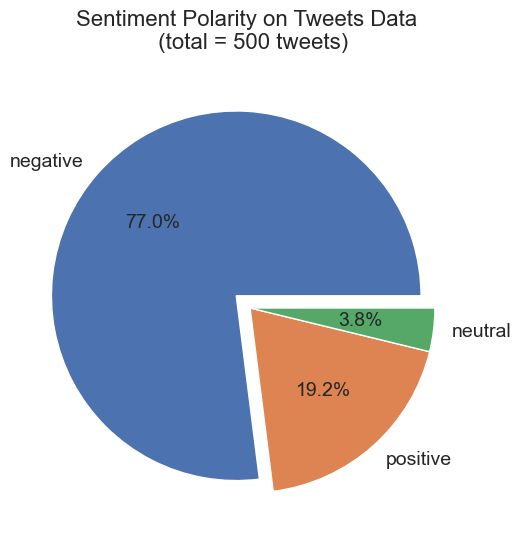

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in data['polarity'].value_counts()]
labels = list(data['polarity'].value_counts().index)
explode = [0.1 if i == 0 else 0 for i in range(len(sizes))]  # set explode values based on index

ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data \n (total = 500 tweets)', fontsize=16, pad=20)

plt.savefig('02. Hasil_No_Stop/polarity.png')
plt.show()
plt.close()

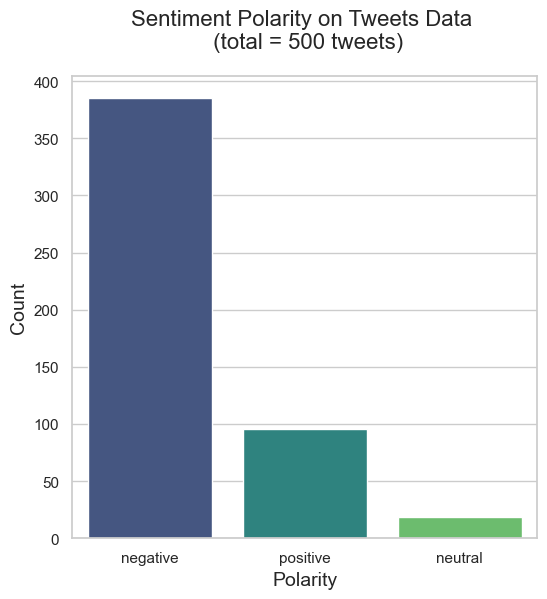

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in data['polarity'].value_counts()]
labels = list(data['polarity'].value_counts().index)

sns.barplot(x=labels, y=sizes, palette='viridis', ax=ax)

ax.set_title('Sentiment Polarity on Tweets Data \n (total = 500 tweets)', fontsize=16, pad=20)
ax.set_xlabel('Polarity', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

plt.savefig('02. Hasil_No_Stop/polarity_batang.png')
plt.show()
plt.close()


In [18]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = data[data['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_normalisasi', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets

,text_normalisasi,polarity_score,polarity
1,iya allah rasanya merinding banget mudah mudahan allah memberikan kelancaran dalam pembangunan ibu kota negara dan berhasil menjadi kota yang terbaik ibu kota negara,15,positive
2,uni emirat arab uea berinvestasi miliar ke kota baru mesir dengan kompensasi tanah seluas juta meter nilai investasi ini sama dengan dana pembangunan ibu kota negara ibu kota negara dalam hal ini presiden uea muhammad bin zayed mbz adalah dewan,14,positive
3,kota kuala kencana berhasil ngebikin harmonisasi antara lingkungan alam dan kehidupan modern gila banget selain itu kota ini juga jadi model pembangunan ibu kota negara ibu kota negara nusantara di kalimantan timur loh,12,positive
4,dalam koleksi foto eksklusif berikut terlihat presiden china xi jinping dan kanselir jerman olaf scholz berjalan-jalan dan berpose untuk difoto di beijing ibu kota china pada april xi bertemu dengan scholz di wisma tamu negara diaoyutai di beijing pada selasa,12,positive
5,presiden jokowi yakin bahwa pemindahan ibu kota nusantara akan memperkuat tata kelola pemerintahan yang lebih baik dan efektif di indonesia ibu kota negara,11,positive
...,...,...,...
92,ibu kota negara nusantara akan memperkuat ketahanan ekonomi dan mengurangi ketergantungan impor baja ibu kota negara,1,positive
93,peningkatan akses kesehatan akan meningkatkan kesejahteraan masyarakat ibu kota negara,1,positive
94,pemerintah akan kembali mendorong percepatan investasi asing ke ibu kota negara ibu kota negara nusantara setelah ada putusan mahkamah konstitusi mk soal sengketa hasil pemilu presiden pilpres ___ danramil dita viralvideo liverpool mainkan operasi ketupat,1,positive
95,semoga dengan pindahnya ibu kota negara ke kalimantan indonesia akan semakin maju,1,positive


In [19]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = data[data['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_normalisasi', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_normalisasi,polarity_score,polarity
1,ada yang berani taruhan ibu kota negara itu hanya akan menjadi lambang sebagai ibu kota negara paling tidak tahun ke depan mengapa karena belum layak dibuat sebagai ibu kota negara yang layak siapa pun presiden berikutnya tidak akan benar tinggal disana dalam waktu yang selayaknya di jakarta,-44,negative
2,iran tidak akan membiarkan kejadian rejim zionis israel yang menyerang kedutaan iran di damsyik syria awal pagi tadi iran melancarkan serangan ratusan peluru berpandu dan dron yang menyasarkan beberapa lokasi termasuk tel aviv ibu kota negara haram itu ikuti berita,-37,negative
3,yang lebih memprihatinkan tidak hanya rumah sakit di sejumlah daerah yang tidak mampu lagi merawat pasien demam berdarah dengue yang membludak tapi juga di ibu kota negarabanyak kalangan yang menyalahkan cuaca sebagai penyebabnyanamun apakah demikian indonesia darurat demam berdarah dengue indonesia sehat dengan islam,-34,negative
4,gerakan pendobrak menuju ke presiden wajib dipersiapkan mulai dari gubernur dki karena dki tidak bisa diubah modus apa pun sebagai ibu kota negara sejak jaman penjajahan banyak perjuangan bila dipimpin orang yang amanah pasti semakin baik makanya yang iri dengki hasut hapus kuliah kerja nyata nepotpol,-32,negative
5,tapi jujur nak tanya apa usaha kita siapa siapa jelah nak kurangkan bilangan haiwan tepi jalan ini negara lain boleh je pastikan haiwan tidak berkeliaran hatyai yang jauh daripada ibu kota bangkok itu pun susah nak nampak haiwan berkeliaran kita sampahpun bersepah weiyh,-31,negative
6,again sembang dengan pakistan pekan olahraga nasional terakhir mellowed down pasal kes ritu negara jiran dia yang sunni itu ada nuclear triad bukan takat deh biasa hadap perang siap boleh lenyapkan ibu kota dengan cuma sebijik nuclear-tipped cmbm terlepas masuk,-30,negative
7,mungkin karena dulu juga disuruh bawa atlas pas sd hapalin benua negara sampai ibu kota sd disuruh hapalin nama menteri sampai pernah dihukum karena tidak ingat iya sampai sekarang juga tidak ingat sih saking sebelnya dulu,-29,negative
8,tidak hanya soal kabinet prabowo juga mesti menghentikan semua warisan proyek jokowi yang bermasalah serta membebani keuangan negara seperti ibu kota negara nusantara dan proyek kereta cepat,-29,negative
9,bye bye bye dki jakarta uu dkj telah disetujui dpr republik indonesia pada maret selangkah lagi jakarta akan meninggalkan statusnya sebagai ibu kota negara penerapan undang-undang daerah khusus jakarta hanya tinggal menunggu peraturan presiden perpres,-28,negative
10,jakarta sebagai ibu kota indonesia telah mengalami banyak masalah seperti macet banjir dan polusi udara yang serius ibu kota negara,-28,negative


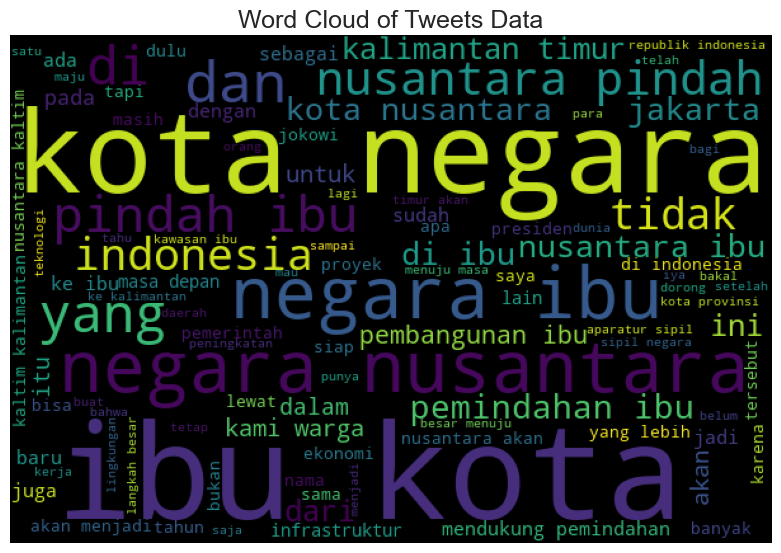

In [20]:
# Visualize word cloud
from wordcloud import WordCloud
list_words=''
for tweet in data['tweet_tokens']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.savefig('02. Hasil_No_Stop/wordcloud.png')
plt.show()

In [21]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)
            
    return positive_words, negative_words

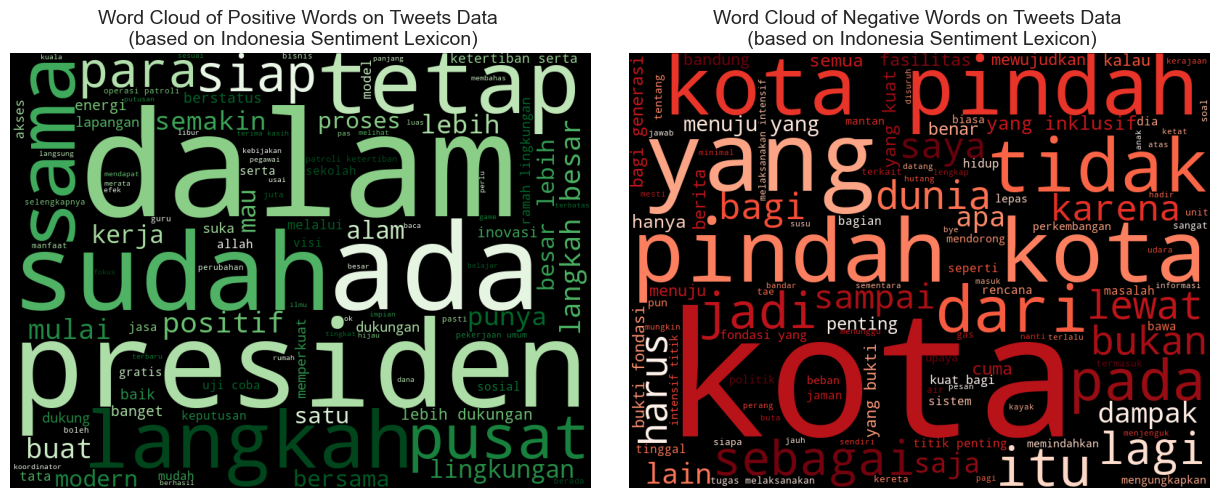

In [24]:
# Visualize positive and negative word cloud

sentiment_words = data['tweet_tokens'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')
plt.savefig('02. Hasil_No_Stop/wordcloud_positif_negatif-01.png')
plt.show()

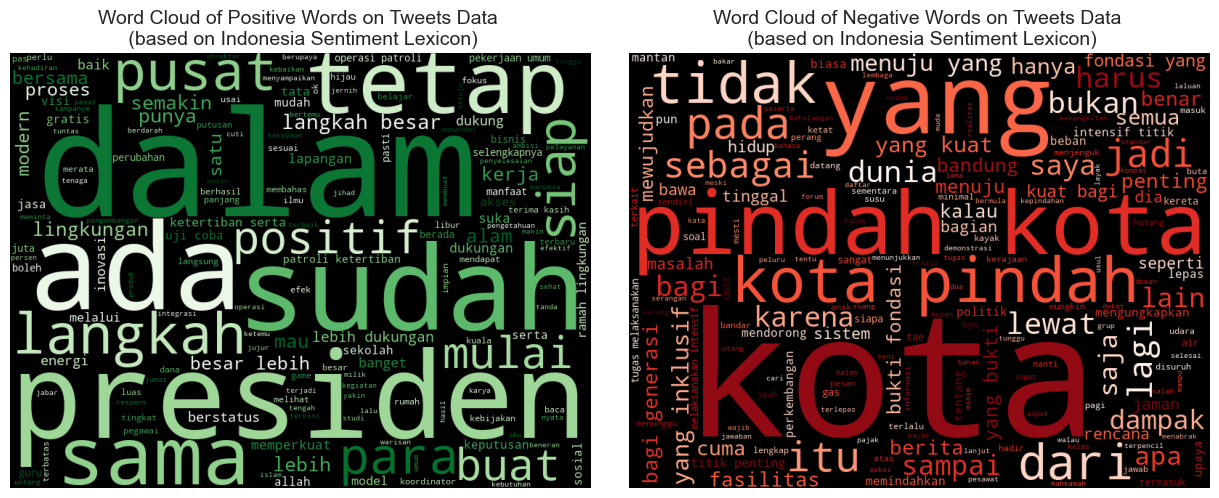

In [25]:
# Visualize positive and negative word cloud

sentiment_words = data['tweet_tokens'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')
plt.savefig('02. Hasil_No_Stop/wordcloud_positif_negatif-02.png')
plt.show()